# KNN Classification of Pulsars Using Summary Statistics of their Integrated Profiles and DM-SNR Curves

## Introduction

### Background and Data
Pulsars are two rotating narrow beams of light that radiate pulses in different directions at regular rapid intervals.  The narrow beams are believed to be the magnetic poles, which spin rapidly as they are not in line with the spin axis. From earth, they appear to be flickering stars, but they are the size of small cities. Pulsars are believed to be neutron stars, meaning they form when the core of a star collapses upon itself in a supernova.

We are using the Predicting Pulsar Star dataset retrieved from Kaggle. Each observation in the dataset contains the mean, standard deviation, skewness, and excess kurtosis of the integrated profile and DM-SNR Curve of each star, and the observed class of each star. The integrated profile of a pulsar is the folded signal array obtained with respect to its rotational period and signal. The shape is unique to each pulsar and can be used to distinguish pulsars from one another. The other four are concerning statistics for the DM-SNR Curve. DM-SNR stands for Dispersion Measure (how the signal of a star broadens) of the Signal to Noise Ratio. 

### Question
*How do different 2-D and 4-D KNN models compare for accurately classifying the type of star based on the summary statistics of a star's integrated profile and DM-SNR Curve?*

Change phrasing: How does the best variable combination predict if a star is a pulsar
Compare best K's but still on training data
Clarify question and communication in applied context

In [2]:
#Read packages into R
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [89]:
#reading the dataset and shortening the column names
pulsar_base_data = read_csv("https://raw.githubusercontent.com/NicoRui/DSCI_100_Project/main/pulsar_data_train.csv", skip = 1,
                            col_names = c("mean_prof", "sd_prof", 
                                          "kurt_prof", "skew_prof", "mean_DMSNR",
                                          "sd_DMSNR","kurt_DMSNR","skew_DMSNR", "target_class")) %>% 
                    mutate(target_class = as_factor(target_class)) %>% 
                    mutate(target_class = fct_recode(target_class,
                                                    "non_pulsar" = '0',
                                                    "pulsar" = '1')) 
           
head(pulsar_base_data)

Parsed with column specification:
cols(
  mean_prof = col_double(),
  sd_prof = col_double(),
  kurt_prof = col_double(),
  skew_prof = col_double(),
  mean_DMSNR = col_double(),
  sd_DMSNR = col_double(),
  kurt_DMSNR = col_double(),
  skew_DMSNR = col_double(),
  target_class = col_double()
)



mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.031324,non_pulsar
156.39844,48.86594,-0.2159886,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.405008,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.546051,112.131721,non_pulsar


In [90]:
set.seed(632)
pulsar_split = initial_split(pulsar_base_data, prop = 0.8, strata = target_class)
pulsar_train = training(pulsar_split)
pulsar_test = testing(pulsar_split)
head(pulsar_train); head(pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.4498741,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.4146523,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.5083638,74.031324,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.4050084,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.5460511,112.131721,non_pulsar
79.34375,42.40217,1.0634129,2.24437669,141.641304,NA,-0.7008088,-1.200653,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
156.3984,48.86594,-0.21598860,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
83.9375,45.71272,0.74877682,1.34290171,1.747492,12.07058,11.838557,NA,non_pulsar
111.7109,46.57054,0.27286063,-0.06164600,2.139632,16.65571,9.353872,97.733760,non_pulsar
127.3281,45.33954,-0.02866461,-0.20653223,3.955686,26.25178,6.815905,46.623791,non_pulsar
108.7578,47.47084,0.23388338,-0.01183974,3.428930,22.80573,7.431087,58.339075,non_pulsar
117.6797,47.45704,0.21480140,-0.13550329,2.731605,21.99329,8.401669,71.587641,non_pulsar


In [64]:
# Table of some summary statistics fore each variable
summary(pulsar_train)

#Pulsar train and test with no NAs
pulsar_train_noNA = drop_na(pulsar_train)
pulsar_test_noNA = drop_na(pulsar_test)

#Distributional Characteristics with no NAs
summary_train_distribution = pulsar_train_noNA %>% 
    group_by(target_class) %>% 
    summarize_all(list(mean = mean, sd = sd)) %>% 
    mutate(across(where(is.numeric), round, 3))
summary_train_distribution

   mean_prof          sd_prof        kurt_prof         skew_prof      
 Min.   :  6.188   Min.   :24.77   Min.   :-1.7380   Min.   :-1.7919  
 1st Qu.:100.625   1st Qu.:42.30   1st Qu.: 0.0230   1st Qu.:-0.1856  
 Median :115.102   Median :46.93   Median : 0.2233   Median : 0.2062  
 Mean   :110.895   Mean   :46.51   Mean   : 0.4859   Mean   : 1.8416  
 3rd Qu.:127.203   3rd Qu.:51.02   3rd Qu.: 0.4769   3rd Qu.: 0.9523  
 Max.   :189.734   Max.   :91.81   Max.   : 8.0695   Max.   :68.1016  
                                   NA's   :1410                       
   mean_DMSNR          sd_DMSNR        kurt_DMSNR       skew_DMSNR      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.945  
 1st Qu.:  1.9122   1st Qu.: 14.40   1st Qu.: 5.815   1st Qu.:  35.208  
 Median :  2.7860   Median : 18.44   Median : 8.465   Median :  83.310  
 Mean   : 12.9438   Mean   : 26.43   Mean   : 8.341   Mean   : 106.211  
 3rd Qu.:  5.3955   3rd Qu.: 28.33   3rd Qu.:10.728   3rd Qu.: 140.

target_class,mean_prof_mean,sd_prof_mean,kurt_prof_mean,skew_prof_mean,mean_DMSNR_mean,sd_DMSNR_mean,kurt_DMSNR_mean,skew_DMSNR_mean,mean_prof_sd,sd_prof_sd,kurt_prof_sd,skew_prof_sd,mean_DMSNR_sd,sd_DMSNR_sd,kurt_DMSNR_sd,skew_DMSNR_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
non_pulsar,116.716,47.316,0.209,0.388,8.970,23.246,8.914,115.468,17.586,6.156,0.335,0.998,24.857,16.744,4.313,110.374
pulsar,56.086,38.607,3.179,16.080,51.245,56.557,2.765,18.455,30.094,8.157,1.921,14.615,46.618,20.025,3.155,48.350


In [65]:
#Standardization of all predictor variables
pulsar_recipe_train = recipe(target_class~., data = pulsar_train_noNA) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_train = bake(pulsar_recipe_train, pulsar_train_noNA)
head(scaled_pulsar_train)

pulsar_recipe_test = recipe(target_class~., data = pulsar_test_noNA) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_test = bake(pulsar_recipe_test, pulsar_test_noNA)
head(scaled_pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.38846539,0.2727719,-0.10101033,-0.2890899,-0.3223887,-0.4052351,-0.19431386,-0.37564593,non_pulsar
-1.31105624,-1.5067285,0.20793440,0.2379656,-0.3478311,-0.4474260,0.23448236,-0.03358552,non_pulsar
0.75114619,0.9813036,-0.32266206,-0.3331020,-0.3364650,-0.2033806,0.03669256,-0.29485595,non_pulsar
-1.00967360,-1.5151753,0.31058988,0.2202116,-0.3349163,-0.2922344,0.01413612,-0.27427784,non_pulsar
-0.06345832,1.3727288,0.07261209,-0.2783359,-0.3346674,-0.3493541,0.24073059,-0.08228881,non_pulsar
-0.61724516,-0.9167066,-0.12656234,-0.1083899,-0.3355800,-0.4144857,-0.10672679,-0.32426322,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.01107067,0.002139272,-0.18496543,-0.28857476,-0.3549535,-0.498483074,0.24305640,-0.05490509,non_pulsar
0.65083778,-0.187662501,-0.49151524,-0.31459801,-0.2897149,0.001776142,-0.33098399,-0.55910137,non_pulsar
-0.10990580,0.140952188,-0.22459219,-0.27962898,-0.3086377,-0.177872560,-0.19184137,-0.44353091,non_pulsar
0.25558396,0.138825140,-0.24399215,-0.30184039,-0.3336879,-0.220226313,0.02768594,-0.31283473,non_pulsar
-0.64565876,-0.885023856,0.08090689,-0.01691419,-0.3022701,-0.259193888,-0.06350674,-0.29278131,non_pulsar
0.13876806,0.430033563,-0.32417289,-0.33386356,-0.2371817,0.157397274,-0.53718862,-0.66868236,non_pulsar


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



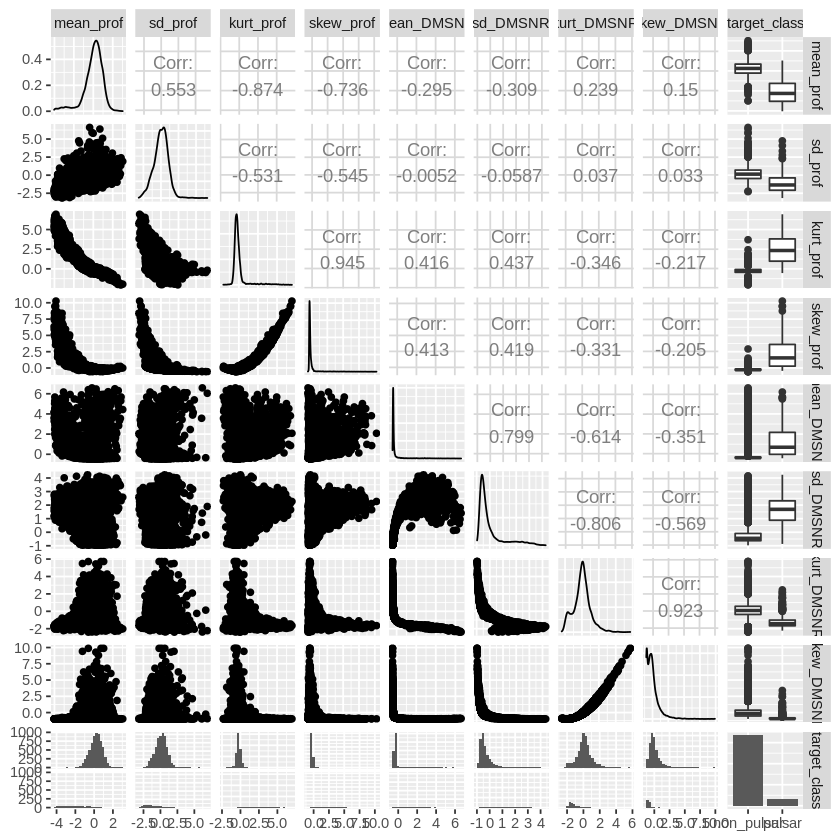

In [76]:
#General display of distributions.  This is not as important as we are pairin
allPlots = ggpairs(scaled_pulsar_train)
allPlots

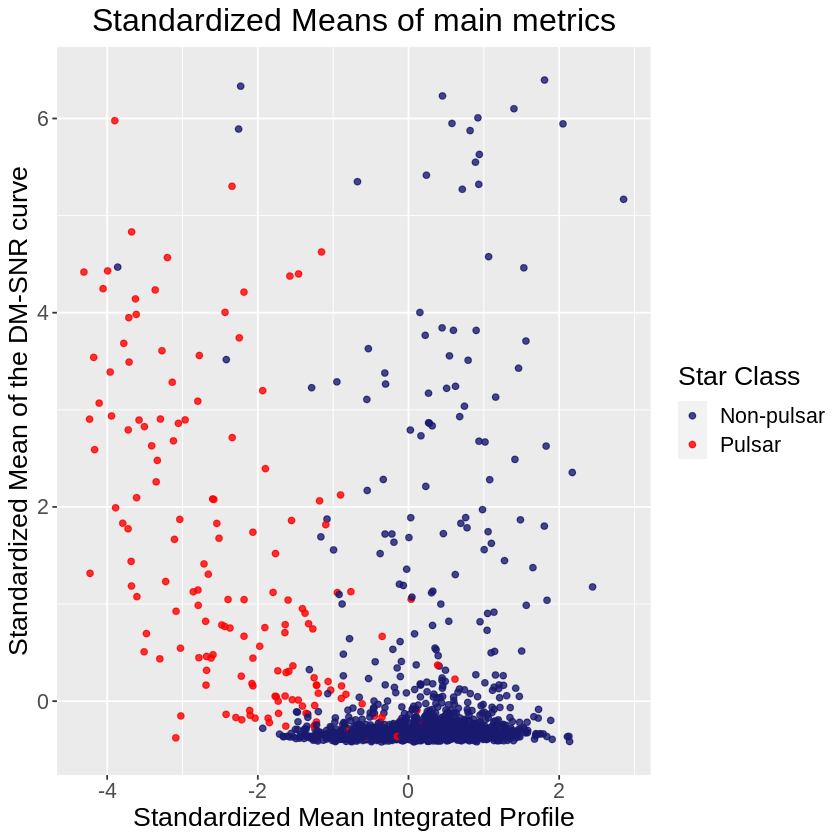

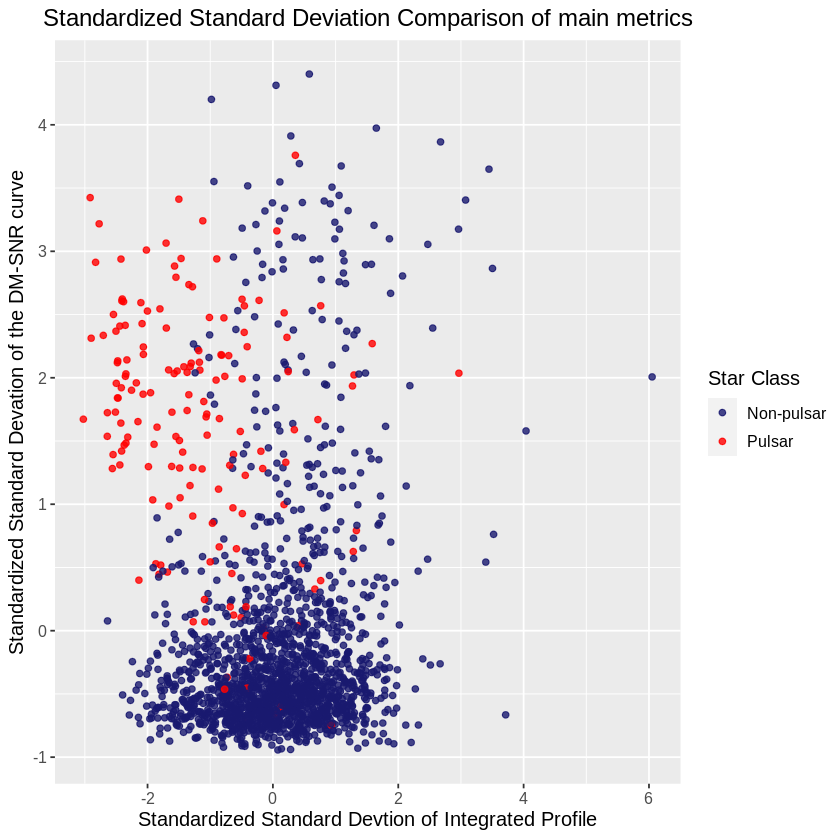

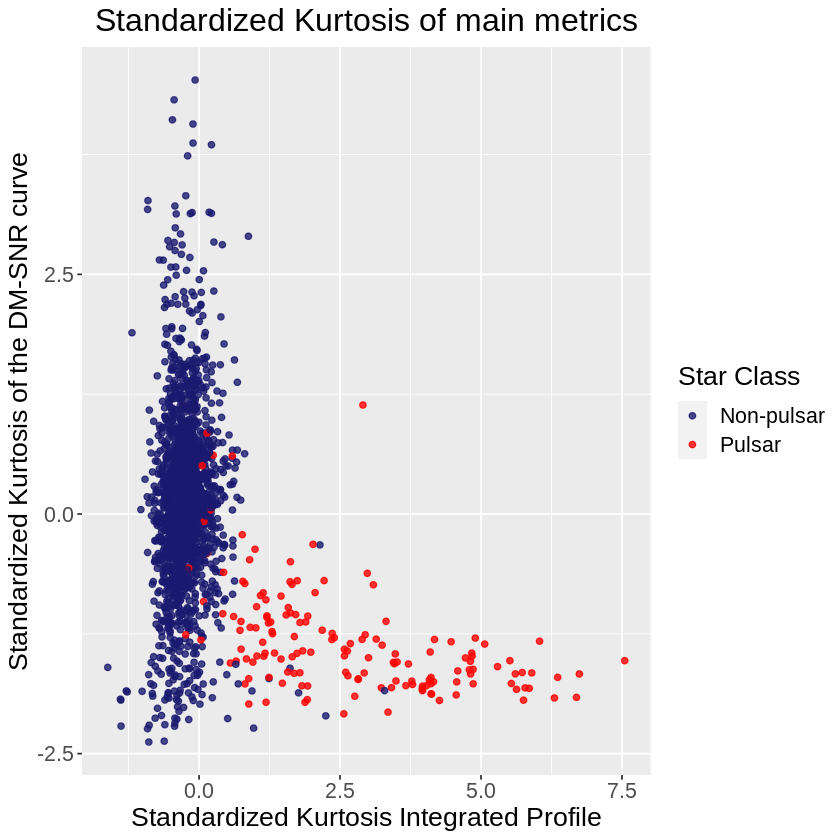

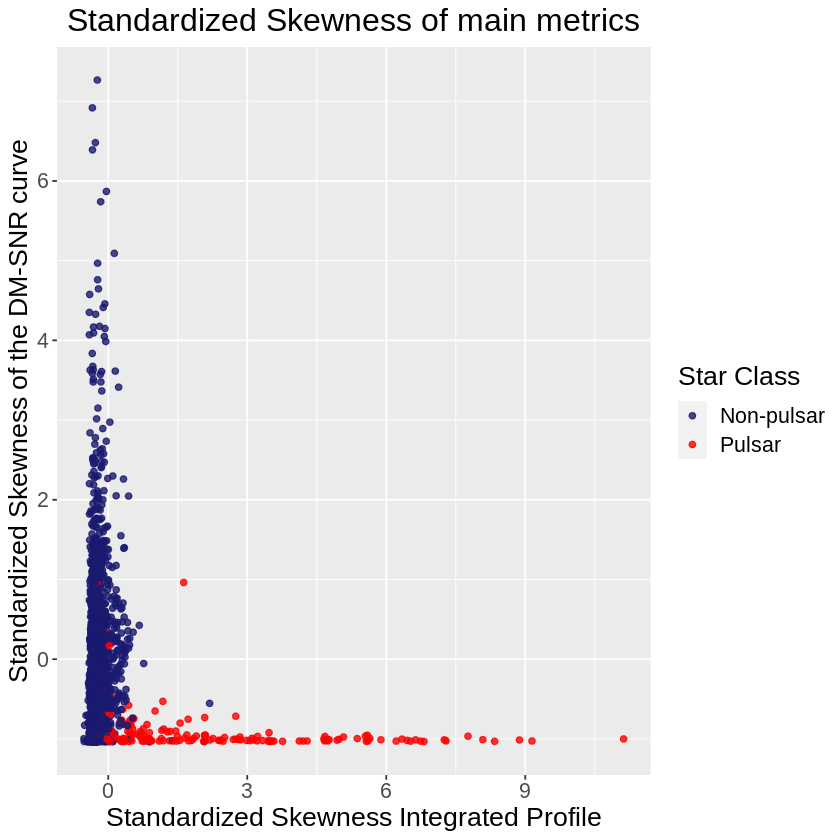

In [66]:
#Visualization for each 2-D pairing, as shown in class
mean_scaled_vis = ggplot(scaled_pulsar_test, aes(x = mean_prof, y = mean_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Mean Integrated Profile", y = "Standardized Mean of the DM-SNR curve",
           color = "Star Class", title = "Standardized Means of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
mean_scaled_vis

sd_scaled_vis = ggplot(scaled_pulsar_test, aes(x = sd_prof, y = sd_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Standard Devtion of Integrated Profile",
         y = "Standardized Standard Devation of the DM-SNR curve",
           color = "Star Class", 
         title = "Standardized Standard Deviation Comparison of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))
sd_scaled_vis

kurt_scaled_vis = ggplot(scaled_pulsar_test, aes(x = kurt_prof, y = kurt_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Kurtosis Integrated Profile",
         y = "Standardized Kurtosis of the DM-SNR curve",
           color = "Star Class", title = "Standardized Kurtosis of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
kurt_scaled_vis

skew_scaled_vis = ggplot(scaled_pulsar_test, aes(x = skew_prof, y = skew_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Skewness Integrated Profile",
         y = "Standardized Skewness of the DM-SNR curve",
           color = "Star Class", title = "Standardized Skewness of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
skew_scaled_vis

## Methods
We will be using all nine columns for the project. We will be pairing off each summary statistic between the integrated profile and DM-SNR Curve to create four 2-D KNN models. For example, the mean of the integrated profile will be paired with the mean of the DM-SNR curve. The variable we will be predicting is the “target_class”.  Since Pulsars are underrepresented, our KNN model will oversample them.  Two 4-D KNN models will be created using all the summary statistics from the integrated profile in one model and the DM-SNR curve in the other model.

### Visualization of results
To visualize our results, we will be using a scatter plot with coloured points and a coloured classification area. We will also use a table of classification rates.

### Expected Outcomes
The visuals indicate that the mean and kurtosis models will be the best of the 2-D KNN models for identifying the pulsars. We expect to find that the standard deviation will be the worst predictor variable, as the scatter plot shows the overlap in the classes' observed values.  It is difficult to predict results for the 4-D KNN models.

### What impact could such findings have?
The visuals indicate that the mean and kurtosis models will be the best of the 2-D KNN models for identifying the pulsars. We expect to find that the standard deviation will be the worst predictor variable, as the scatter plot shows the overlap in the classes' observed values.  It is difficult to predict results for the 4-D KNN models.

### What future questions could this lead to?
In the future, once a pulsar is identified, we can attempt to calculate its age using these observations and other predictors.  We can also look and see if these variables are related to other stars becoming pulsars.


## References

Cofield, C. (2016, April 22). What Are Pulsars? Space.com. 
https://www.space.com/32661-pulsars.html. 

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & 
Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17=

Hobbs, M. (2020, November 17). An Introduction to Pulsars. Australia Telescope National 
Facility. https://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html.

Lounge, C.-learning. (2020, August 26). Predicting Pulsar Star. Kaggle. 
https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate?select=pulsar_data_train.csv. 

Rowan, L., & Coontz, R. (2004, April 23). The Strange and Twisted World of Pulsars. 
Science. https://science.sciencemag.org/content/304/5670/531.  

Lyon, R. (2017, February 14). HTRU2 Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/HTRU2

Swinburne University of Technology. (2020). Pulsar Dispersion Measure. COSMOS. https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure

The University of Sheffield. (n.d.). L14 Signal-to-Noise. PHY217 Observational Techniques for Astronomers. http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html